In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import copy

In [2]:
class Perceptron:
    def __init__(self, epochs=50, learning_rate=0.1):
        self.epochs = epochs
        self.learning_rate = learning_rate

    def predict(self, X):
        return np.sign(self.predict_value(X))

    def predict_value(self, X):
        return np.dot(X, self.parameters[1:]) + self.parameters[0]

    def fit(self, X, Y):
        if (np.unique(Y) != np.array([-1, 1])).any():
            raise ValueError("Labels must be -1 and 1")

        self.parameters = np.zeros(X.shape[1]+1)
        for _ in range(self.epochs):
            for x, y in zip(X, Y):
                diff = y - self.predict(x.reshape(1, -1))
                self.parameters[1:] += self.learning_rate * diff * x
                self.parameters[0] += self.learning_rate * diff.item()


class KernelPerceptron:
    def __init__(self, kernel, epochs=50, learning_rate=0.1):
        self.kernel = kernel
        self.epochs = epochs
        self.learning_rate = learning_rate

    def predict(self, X):
        return np.sign(self.predict_value(X))

    def predict_value(self, X):
        return np.dot(self.kernel(X), self.parameters)

    def fit(self, X, Y):
        if (np.unique(Y) != np.array([-1, 1])).any():
            raise ValueError("Labels must be -1 and 1")

        self.parameters = np.zeros(X.shape[0])
        for _ in range(self.epochs):
            for i, (x, y) in enumerate(zip(X, Y)):
                diff = y - self.predict(x.reshape(1, -1))
                self.parameters[i] += self.learning_rate * diff.item()


class OneVersusRestClassifier:
    def __init__(self, classifier):
        self.clf = classifier

    def predict(self, X):
        numbered_class = np.argmax([c.predict_value(X) for c in self.clfs], axis=0)
        return self.unique[numbered_class]

    def fit(self, X, Y):
        self.unique, y = np.unique(Y, return_inverse=True)
        num_classes = len(self.unique)
        self.clfs = [copy.deepcopy(self.clf) for _ in range(num_classes)]
        for i in range(num_classes):
            y_binary = np.array([1 if yy == i else -1 for yy in y])
            self.clfs[i].fit(X, y_binary)

Perceptron accuracy: 0.79
Kernel Perceptron accuracy: 1.0


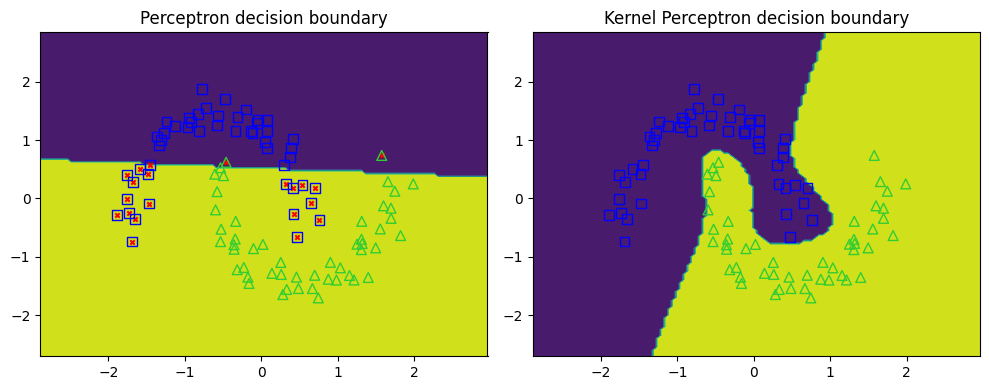

In [3]:
X, y = datasets.make_moons(n_samples=100, noise=0.1, random_state=42)

# Only use the first two features and normalize the data
X = X[:, [0,1]]
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Kernels for the perceptron (includes bias)
def linear_kernel(X_in):
    return X_in.dot(X.T) + 1

def polynomial_kernel(X_in, degree=5):
    return (X_in.dot(X.T) + 1) ** degree

def rbf_kernel(X_in, gamma=0.1):
    distances = np.sum((X_in[:, np.newaxis] - X) ** 2, axis=-1)
    return np.exp(-distances * gamma)

# Train the perceptrons
perceptron = OneVersusRestClassifier(classifier=Perceptron())
kernel_perceptron = OneVersusRestClassifier(classifier=KernelPerceptron(kernel=polynomial_kernel))
kernel_perceptron.fit(X, y)
perceptron.fit(X, y)

# Plot the decision boundaries
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X_predict = np.c_[xx.ravel(), yy.ravel()]

for clf, name, a in zip([perceptron, kernel_perceptron], ["Perceptron", "Kernel Perceptron"], ax):
    Z = clf.predict(X_predict)
    Z = Z.reshape(xx.shape)
    a.contourf(xx, yy, Z)
    a.set_title(f"{name} decision boundary")
    # Plot the misclassified training points
    y_pred = clf.predict(X)
    a.scatter(X[y != y_pred, 0], X[y != y_pred, 1], color="r", marker="x", s=10)
    # Print the accuracy
    print(f"{name} accuracy:", np.mean(clf.predict(X) == y))

# Plot the data
colors, markers = ["blue", "limegreen", "gray", "cyan"], "s^oxv<>"
for a in ax:
    for i in range(len(np.unique(y))):
        a.scatter(X[y == i, 0], X[y == i, 1], color=colors[i], marker=markers[i], s=50, facecolors="none")

fig.tight_layout()
plt.show()
